### Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

### Load Data

In [ ]:
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load("tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

### Image Preprocessing

In [ ]:
## check existing image size
train_ds[0].shape

TensorShape([442, 1024, 3])

In [ ]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

In [ ]:
train_labels

<tf.Tensor: shape=(2569,), dtype=int64, numpy=array([2, 3, 3, ..., 0, 2, 0])>

In [ ]:
## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [ ]:
train_labels[0]

array([0., 0., 1., 0., 0.], dtype=float32)

### Use Pretrained VGG16 Image Classification model

# **Load a pre-trained CNN model trained on a large dataset**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
train_ds[0].shape

TensorShape([150, 150, 3])

In [ ]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)

In [ ]:
## will not train base mode
# Freeze Parameters in model's lower convolutional layers
base_model.trainable = False 

In [ ]:
## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [ ]:
## model details
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

**Add custom classifier with two dense layers of trainable parameters to model**

In [ ]:
#add our layers on top of this model
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

**Train classifier layers on training data available for task**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [ ]:
history=model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
65/65 [==============================] - 20s 126ms/step - loss: 1.6295 - accuracy: 0.5041 - val_loss: 1.1216 - val_accuracy: 0.5759
Epoch 2/50
65/65 [==============================] - 6s 98ms/step - loss: 0.7803 - accuracy: 0.7095 - val_loss: 1.0138 - val_accuracy: 0.6401
Epoch 3/50
65/65 [==============================] - 6s 98ms/step - loss: 0.5985 - accuracy: 0.7981 - val_loss: 0.8845 - val_accuracy: 0.6984
Epoch 4/50
65/65 [==============================] - 6s 98ms/step - loss: 0.4167 - accuracy: 0.8428 - val_loss: 1.0356 - val_accuracy: 0.6848
Epoch 5/50
65/65 [==============================] - 6s 99ms/step - loss: 0.3029 - accuracy: 0.8881 - val_loss: 0.9954 - val_accuracy: 0.7296
Epoch 6/50
65/65 [==============================] - 6s 99ms/step - loss: 0.2083 - accuracy: 0.9192 - val_loss: 1.0856 - val_accuracy: 0.7218
Epoch 7/50
65/65 [==============================] - 6s 100ms/step - loss: 0.1784 - accuracy: 0.9382 - val_loss: 1.0919 - val_accuracy: 0.7257
Epoch 8/50

In [ ]:
los,accurac=model.evaluate(test_ds,test_labels)
print("Loss: ",los,"Accuracy: ", accurac)

35/35 [==============================] - 3s 78ms/step - loss: 0.1735 - accuracy: 0.9391
Loss:  0.17345084249973297 Accuracy:  0.9391462206840515


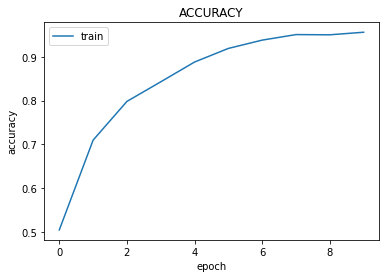

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
y_pred = model.predict(test_ds)
y_classes = [np.argmax(element) for element in y_pred]
#to_categorical(y_classes, num_classes=5)
#to_categorical(test_labels, num_classes=5)
print(y_classes[:10])
print("\nTest")
print(test_labels[:10])

35/35 [==============================] - 3s 77ms/step
[2, 3, 3, 4, 3, 0, 1, 0, 0, 2]

Test
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
